In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib import font_manager
font_manager.fontManager.addfont("C:\Windows\Fonts\FiraSans-Regular.ttf")
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(42)

sns.set_theme()
sns.set(font="Fira Sans")


In [2]:
import svd

Python source: [svd.py](https://github.com/doabell/451-blog/blob/main/posts/unsupervised/svd.py)

Image credits: [atlas.brussels](https://atlas.brussels/community-detection-louvain-method/)

Instructions can be found at [Unsupervised Learning with Linear Algebra](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-image-processing.html).

## SVD Image Compression
In part 1, we explore image compression with singular value decomposition (SVD).

SVD is a matrix decomposition (or factorization) method,
and is used in principal component analysis (PCA) - see discussions on the relationship between SVD and PCA,
 on [Cross Validated](https://stats.stackexchange.com/questions/134282/) and the [Math Stack Exchange](https://math.stackexchange.com/questions/3869/).

### Reconstruction
Here is a brief demo from the blog post instructions.

We first generate a vector representing a greyscale image:

In [3]:
a_1 = np.random.randint(1, 3, (5, 3))
a_2 = np.random.randint(1, 3, (3, 7))

A = a_1 @ a_2 + 0.1*np.random.randn(5, 7)

In numpy, the actual SVD process is a one-liner.

`sigma` contains the *singular values* of $A$; we reconstruct $A$ after creating $D$, the corresponding diagonal matrix.

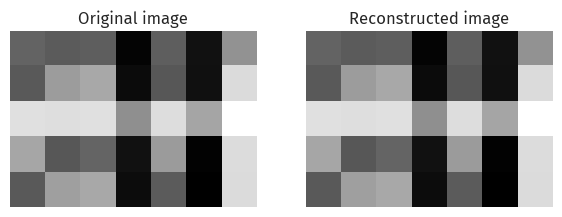

In [4]:
U, sigma, V = np.linalg.svd(A)

D = np.zeros_like(A,dtype=float)
D[:min(A.shape),:min(A.shape)] = np.diag(sigma)

A_recon = U @ D @ V

svd.compare_images(A, A_recon)

We can visually confirm, at a glance, that these two images are indeed identical.

### Compression
By keeping only the first $k$ columns of $U$, $k$ values of $D$, and $k$ rows in $V$, we can reconstruct something similar to the same image, with less storage.

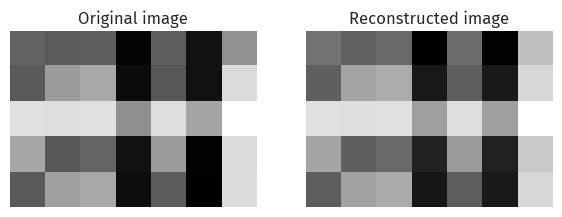

In [5]:
k = 2
U_ = U[:,:k]
D_ = D[:k, :k]
V_ = V[:k, :]

A_ = U_ @ D_ @ V_

svd.compare_images(A, A_)

Here, we have constructed a similar image, with less storage (by shrinking $U$, $D$, and $V$).

### Real-life image

Image by [Wells Baum on Unsplash](https://unsplash.com/photos/L-n-SIvQBHw).

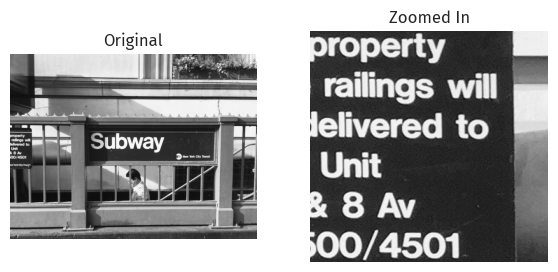

In [6]:
url = "https://unsplash.com/photos/L-n-SIvQBHw/download?force=true"
# url = "https://unsplash.com/photos/L-n-SIvQBHw/download?force=true&w=640"

xlim = (0, 340)
ylim = (1390, 1060)

mta = svd.url2img(url)

svd.zoom_images(mta, xlim, ylim)

#### Number of components
We first try compressing by specifying the number of components.

Since this is a large image, `20` might be a good guess.

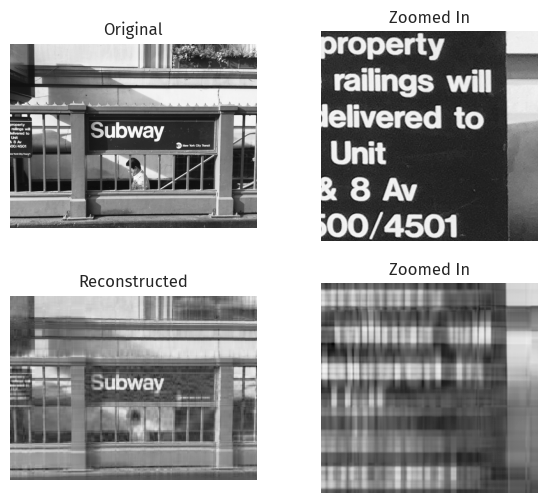

In [7]:
mta_ = svd.svd_reconstruct(mta, k=20)

svd.zoom_images(mta_, xlim, ylim, orig=mta)

At `k=20`, we can make out the "Subway" text, but not the smaller text on the left.

The contrast is also lower; the reconstructed dark parts are not as dark.

We experiment with various values of $k$:

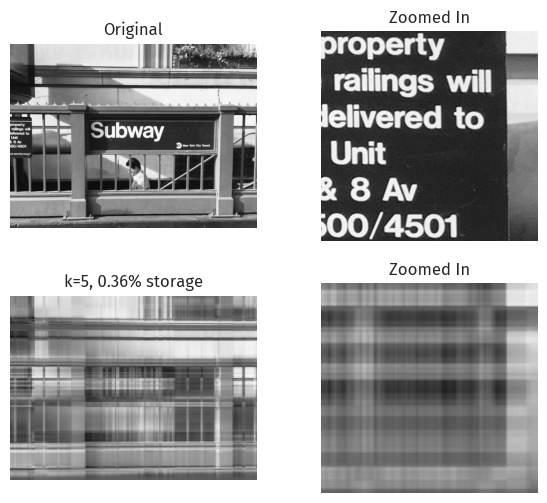

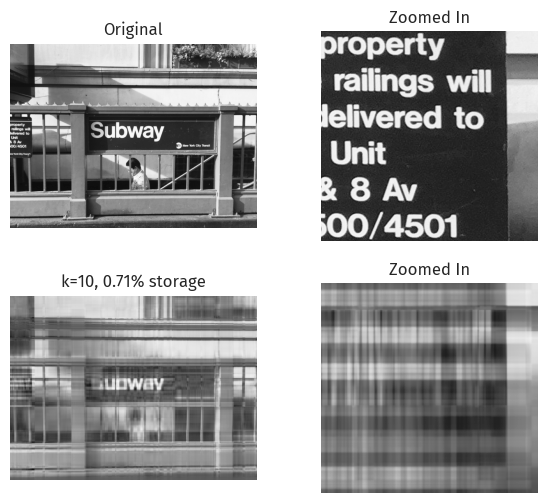

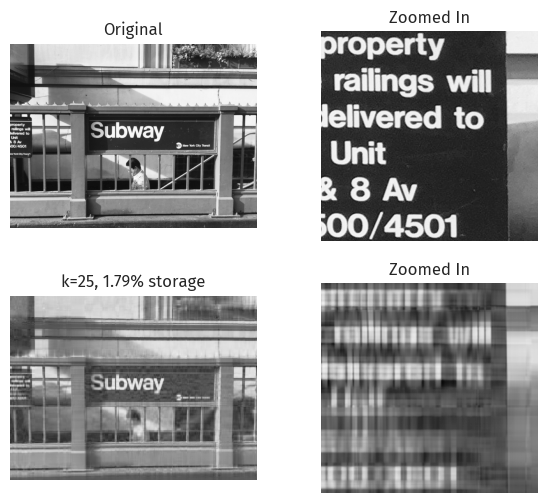

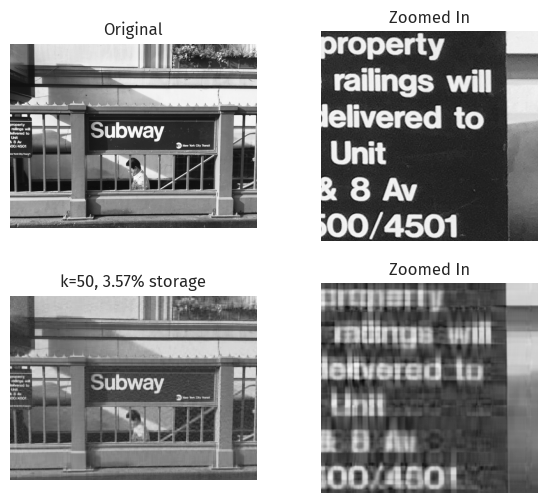

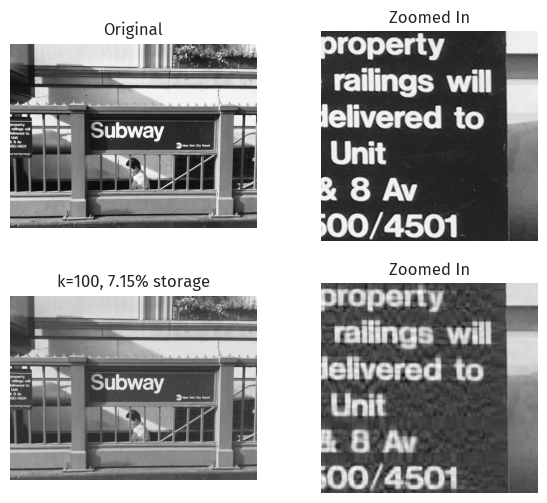

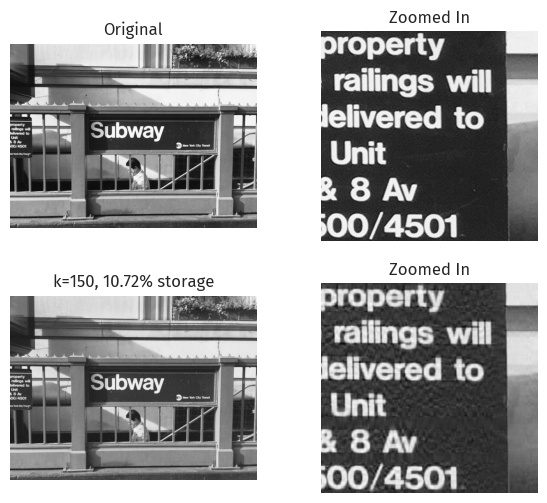

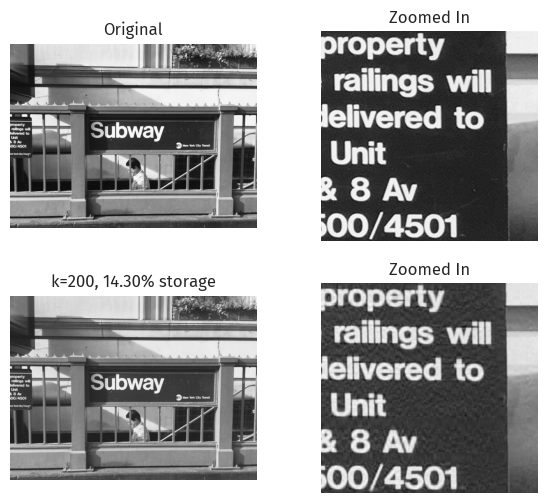

In [20]:
svd.svd_experiment(mta)

We observe the zoomed-in text getting clearer as we increase $k$.

The contrast also approaches the original image.

#### Discussion on size
We investigate the *compression rate* of image compression using SVD, 
which is the size needed for reconstruction as a fraction of the size of the original image.

Unlike the flexible (memory) size of Python's `int`, each item in NumPy's arrays have a fixed size of `numpy.ndarray.itemsize`,
so the total size of a NumPy array, `numpy.ndarray.nbytes`, is simply `numpy.ndarray.itemsize * numpy.ndarray.size`.

(No, the sparse matrices are in [SciPy](https://docs.scipy.org/doc/scipy/reference/sparse.html).)

NumPy's `numpy.single` is "compatible with `C float`"[^1], so this is typically 8 bytes.
(You can fire up `gcc` to [make sure](https://en.cppreference.com/w/cpp/types/numeric_limits/is_iec559).)
Even if it's not, the size would stay constant, so as a proportion this can be ignored.

[^1]: https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.single

One other thing to ignore is NumPy arrays' overhead,
which contributes to the difference observed between `numpy.ndarray.nbytes` and `sys.getsizeof()`.
As our NumPy array gets larger, however, this difference becomes very small, so we will ignore this too.

For the SVD of a matrix image of size $m \times n$,
the size of $U$ is $m \times m$, and the size of $V$ is $n \times n$.
While $D$ has shape $\min(m, n) \times \min(m, n)$,
it is a diagonal matrix that can be reproduced from a 1-D vector of size $\min(m, n)$.

When compressed by keeping the top $k$ singular values, the sizes of $U$, $V$, and $D$
becomes $m \times k$, $n \times k$, and $k \times k$ (constructable with $k$) respectively.

Since the original image has size $m \times n$, the resulting compression factor would be $k\frac{m+n+1}{mn}$.

#### Compression factor
At `k=200`, the resulting compression factor is 14.30%, and the image preserves much of its original details.

We can observe how a larger compression factor performs:

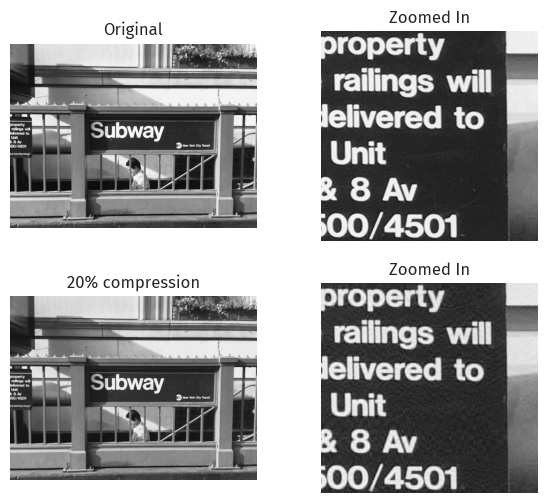

In [22]:
mta_ = svd.svd_reconstruct(mta, cf=0.2)

svd.zoom_images(mta_, xlim, ylim, orig=mta, text=f"20% compression")

Even in the zoomed-in portion, apart from some spots, the reconstructed image is very similar to the original image.

#### Epsilon

We can also experiment with `epsilon` for the singular values:

k = 143


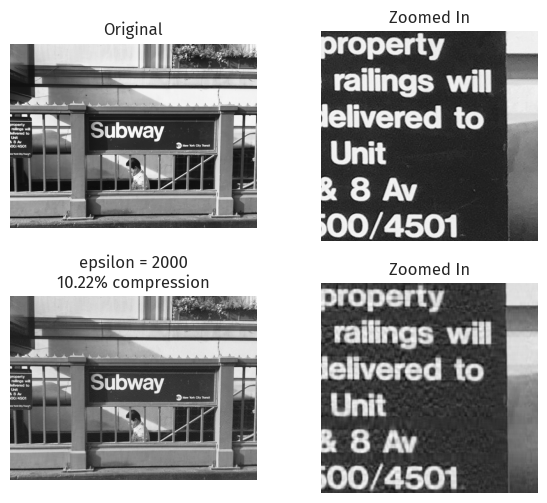

In [49]:
mta_, U, sigma, V = svd.svd_reconstruct(mta, epsilon=2000, store_vals=True)

m, n = mta.shape

k = sigma.shape[0]

percent = 100 * k * (m + n + 1) / (m * n)

svd.zoom_images(mta_, xlim, ylim, orig=mta, text=f"epsilon = 2000\n{percent:.2f}% compression")

print(f"k = {k}")

An `epsilon = 2000` for this image translates to `k=143` at around 10.22% compression, similar to 10.72% at `k=150` above.

## What about JPEG?

JPEG image compression does not use SVD, but instead uses DCT (discrete cosine transform).

From [Wikipedia's page on JPEG](https://en.wikipedia.org/wiki/JPEG):

> The human eye is good at seeing small differences in brightness over a relatively large area, but not so good at distinguishing the exact strength of a high frequency brightness variation.

Therefore, a pre-determined quantization matrix can take advantage of such traits and yield a higher compression ratio.

SVD compression, on the other hand, does not seem to utilize human perception.

It is also notable that [DCT is present](https://en.wikipedia.org/wiki/Discrete_cosine_transform) in many well-known formats, including HEIF, MPEG, H.264, MP3, AAC, and Opus.

Therefore, there might be system- or hardware-level optimizations possible with DCT-compressed file formats over alternative methods like SVD.